# scikit-HEROS: Demonstration Notebook
This notebook is set up as a demonstration for running scikit-HEROS.

***
## Imports:

In [1]:
import os
import pickle
from pprint import pformat as pf #for pickle debugging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from sklearn.metrics import classification_report
# If pip installed
#from skheros.heros import HEROS
# If locally run
from src.skheros.heros import HEROS

current_working_directory = os.getcwd()
print(current_working_directory)

c:\Users\ryanu\OneDrive\Documents\GitHub\scikit-heros


***
## Set Up Local Run Parameters


In [2]:
local_save = True
folder_path = './output'
output_name = 'demo'
if not os.path.exists(folder_path):
        os.makedirs(folder_path)
if local_save:
    output_folder = './output'
else:
    output_folder = folder_path

full_run = True

***
## Data

### Load Example Dataset (6-bit Multiplexer)
6-bit Multiplexer dataset includes only 64 unique instances and 6 features (all predictive), with A_0 and A_1 being important to predict every instance and R_0, R_1, R_2, and R_3; each predictive in only 1/4 of the 64 instances. All features and outcome (i.e. 'class') are binary-valued. This small, simpler dataset is still challenging in that it involves finding both 3-way feature interactions and a heterogenous pattern of association to solve. This data includes no missing values, and all features are treated as categorical since they are binary (however they could also be treated as quantitative).

In [3]:
df = pd.read_csv('test/datasets/Multiplexer6.csv')
#df = pd.read_csv('test/datasets/Multiplexer11.csv')
#df = pd.read_csv('test/datasets/Multiplexer20.csv')
outcome_label = 'class'
print(df.head())

   A_0  A_1  R_0  R_1  R_2  R_3  class
0    0    0    0    0    0    0      0
1    0    0    0    0    0    1      0
2    0    0    0    0    1    0      0
3    0    0    0    0    1    1      0
4    0    0    0    1    0    0      0


### Prepare Dataset for Analysis
Data used for training HEROS has the following requirements:
1. The training data must be passed as separate array-like objects including:
    1. 'X' {n_samples, n_quanatiative_features} Training instances of features to be treated as quantitative (must be numeric).
    2. 'Xc' {n_samples, n_categorical_features} Training instances of features to be treated as categorical (numeric recommended, but non-numeric will be numerically encoded).
    3. 'y' {n_samples} Training labels of the outcome variable.
2. Either 'X', 'Xc', or both must be provided.
3. 'y must always be provided and must not include any missing values.
4. Missing values are allowed in 'X' or 'Xc' but data instances should be excluded that have missing values for all features. Note, HEROS treats missing values as missing, i.e. no imputation of values are made or needed. Any rule that specifies a given feature will not match an instance with a missing value at that instance. 
5. (OPTIONAL) 'pop_df' is a DataFrame of a previously trained HEROS rule population that can be uploaded to initialize a new HEROS run.
6. (OPTIONAL) 'ek' is a numpy array or list of expert knowledge weights for all quantitative and categorical features in the dataset. They must be formatted as follows:
    1. This list must have the same number of elements as there are total features in the dataset (ordered in the same way)
    2. If a mix of quantiative and categorical features are loaded, HEROS will combine them with all quantitative features first, followed by all categorical features in the same order as provided in 'X' or 'Xc'.

For this demo, the 6-bit multiplexer data requires minimal preparation, i.e. only breaking the loaded dataset into separate array-like objects. 'ek' scores are provided for this dataset which were calculated outside of this notebook by running the MultiSURF (feature importance estimation) algorithm on this same dataset. For MultiSURF, see our scikit-rebate respository at https://github.com/UrbsLab/scikit-rebate. 

In [4]:
X = df.drop(outcome_label, axis=1)
feature_names = X.columns # 6-bit multiplexer feature names are ['A_0','A_1','R_0', 'R_1', 'R_2','R_3']
cat_feat_indexes = list(range(X.shape[1])) #all feature are categorical so provide indexes 0-5 in this list for 6-bit multiplexer dataset
X = X.values
y = df[outcome_label].values #outcome values

ek = [0.05271707, 0.05271707, 0.00982932, 0.00982932, 0.00982932, 0.00982932] #expert knowlege feature weights for A_0, A_1, R_0, R_1, R_2, and R_3
#ek = [0.05271707, 0.05271707, 0.05271707, 0.00982932, 0.00982932, 0.00982932, 0.00982932,0.00982932, 0.00982932, 0.00982932, 0.00982932] #expert knowlege feature weights for 11bit multiplexer
#ek = [0.05271707, 0.05271707, 0.05271707, 0.05271707, 0.00982932, 0.00982932, 0.00982932, 0.00982932,0.00982932, 0.00982932, 0.00982932, 0.00982932, 0.00982932, 0.00982932, 0.00982932, 0.00982932,0.00982932, 0.00982932, 0.00982932, 0.00982932]

***
## Run HEROS (Training)

In [5]:
# Initialize HEROS algorithm with run parameters
heros = HEROS(outcome_type='class',iterations=10000, pop_size=500, cross_prob=0.8, mut_prob=0.04, nu=1, beta=0.2, theta_sel=0.5,
              fitness_function='pareto',subsumption='both', use_ek=True, rsl=None, feat_track='end', model_iterations=200,
              model_pop_size=100, new_gen=1.0, merge_prob=0.1, pop_init_type=None, compaction='sub',
              track_performance=1000,random_state=42, verbose=True)

heros = heros.fit(X, y, cat_feat_indexes=cat_feat_indexes, ek=ek)


Data Manage Summary: ------------------------------------------------
Number of quantitative features: 0
Number of categorical features: 6
Total Features: 6
Total Instances: 64
Feature Types: [1, 1, 1, 1, 1, 1]
Missing Values: 0
Classes: [0, 1]
Class Counts: {0: 32, 1: 32}
Class Weights: {0: 0.5, 1: 0.5}
Majority Class: 0
Quantiative Feature Range: [[inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf]]
Categorical Feature Values: [[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
Average States: 2.0
Rule Specificity Limit: 6
--------------------------------------------------------------------
   Iteration  Pred.Acc.Est.  Total Time  Cover Time  Equality Time  \
0       1000          0.701       0.409         0.0          0.016   

   Match Time  Eval Time  FT Time  Subsume Time  Select Time  Mate Time  \
0       0.043      0.208      0.0         0.037        0.016      0.031   

   Delete Time  Predict Time  
0        0.044         0.013  
   Iteration  Pred.Acc.E

***
## HEROS Trained Rule Population (Phase 1)
### Get DataFrame and save to .csv

In [6]:
pop_df = heros.get_pop()
pop_df.to_csv(output_folder+'/'+str(output_name)+'_rule_pop.csv', index=False)


### Vizualize Rule Population on Pareto Front Fitness Landscape

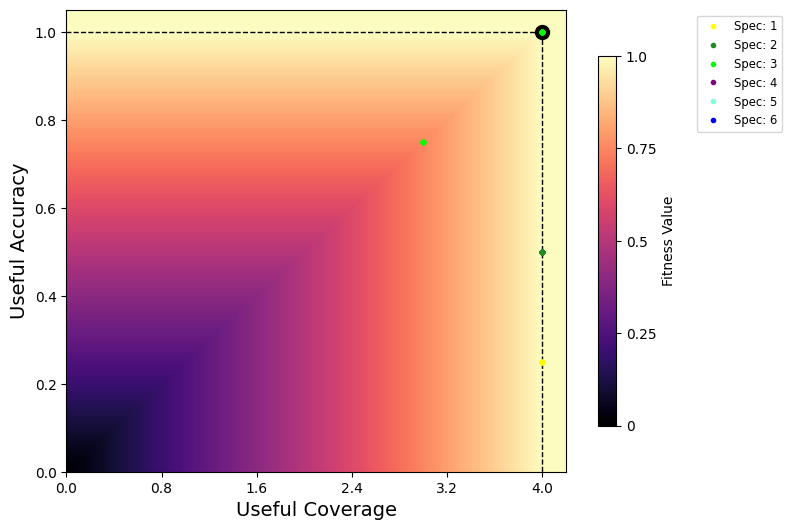

In [7]:
if full_run:
    resolution = 500
    plot_rules = True
    color_rules = True
    heros.get_rule_pareto_landscape(resolution, heros.rule_population, plot_rules, color_rules,show=True,save=True,output_path=folder_path,data_name=output_name)
    #heros.rule_pareto.plot_pareto_landscape(resolution, heros.rule_population, plot_rules, color_rules,show=True,save=True,output_path=folder_path,data_name=output_name)

### Vizualize Rule Population (Feature Specification) as a Rule-Clustered Heatmap (With Optional Rule-Weighting)
Parameters:
* *feature_names*: a list of feature names for the entire training dataset (given in original dataset order)
*  *weighting*: indicates what (if any) weighting is applied to individual rules for the plot ('useful_accuracy', 'fitness', None)
*  *specified_filter*: the number of times a given feature must be specified in rules of the population to be included in the plot (must be a positive integer or None)
*  *display_micro*: controls whether or not additional copies of rules (based on rule numerosity) should be included in the heatmap (True or False) 
*  *show*: indicates whether or not to show the plot (True or False)
*  *save*: indicates whether or not to save the plot to a specified path/filename (True or False)
*  *output_path*: a valid folder path within which to save the plot (str of folder path)
*  *data_name*: a unique name precursor to give to the plot (str)

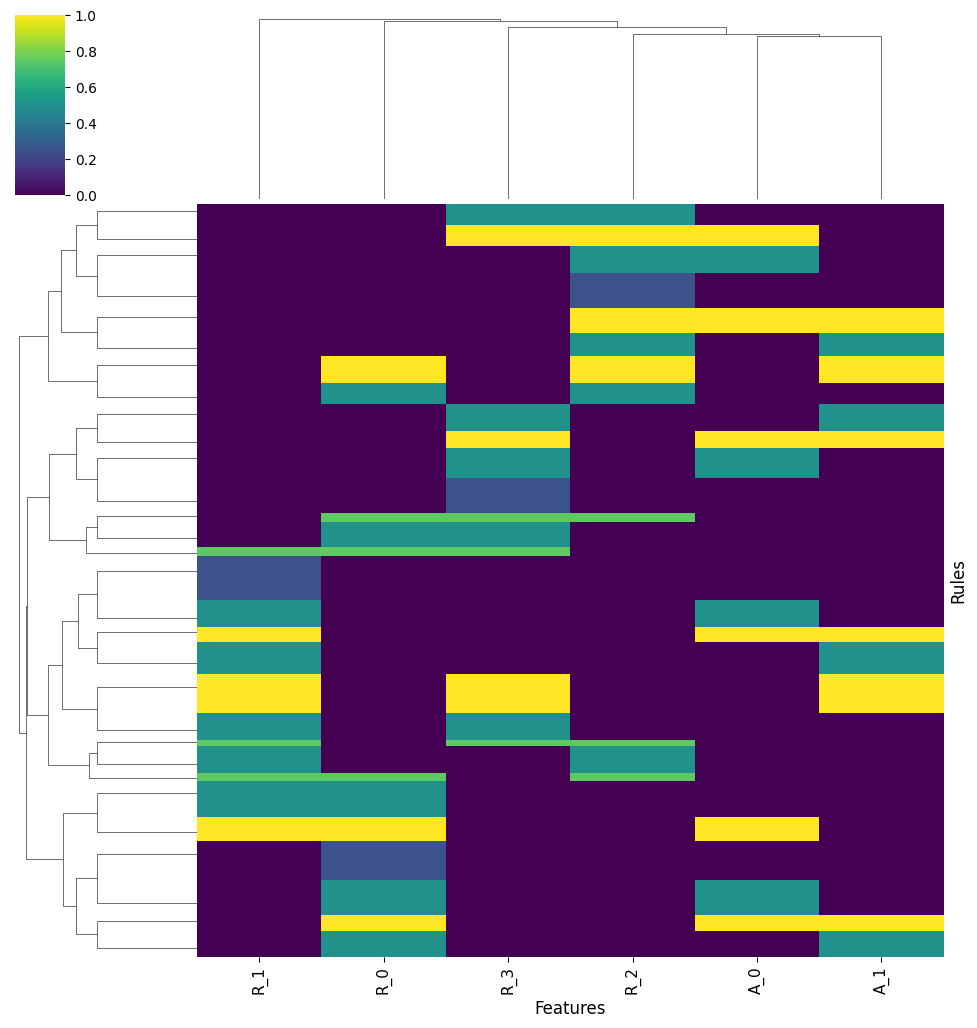

In [8]:
if full_run:
    heros.get_rule_pop_heatmap(feature_names, weighting='useful_accuracy', specified_filter=None, display_micro=True, show=True, save=True, output_path=folder_path, data_name=output_name)
    #heros.rule_population.plot_rule_pop_heatmap(feature_names, weighting='useful_accuracy', specified_filter=None, display_micro=True, show=True, save=True, output_path=folder_path, data_name=output_name)

### Vizualize Rule Population (Feature Specification) as a Network (With Optional Rule-Weighting)

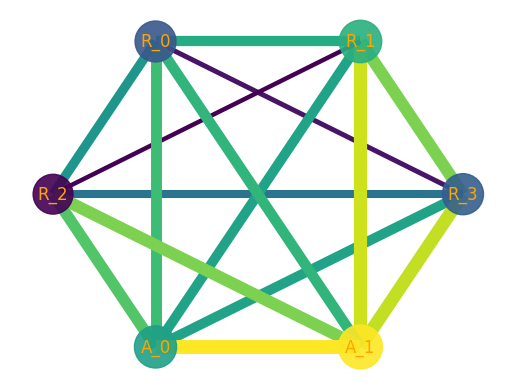

In [9]:
if full_run:
    node_size = 1000
    edge_size = 10
    weighting = 'useful_accuracy'# 'useful_accuracy', 'fitness', None
    display_micro = True
    heros.rule_population.plot_rule_pop_network(feature_names, weighting=weighting, display_micro=display_micro, node_size=node_size, edge_size=edge_size, show=True, save=True, output_path=folder_path, data_name=output_name)

***
## HEROS Feature Tracking Scores (Rule Population)
### Get DataFrame and save to .csv

In [10]:
ft_df = heros.get_ft()
ft_df.to_csv(output_folder+'/'+str(output_name)+'_ft.csv', index=False)
ft_df.shape

(64, 7)

### Generate Clustered Heatmap of Feature Tracking Scores
Simple first visualization that does not show instance indexes.

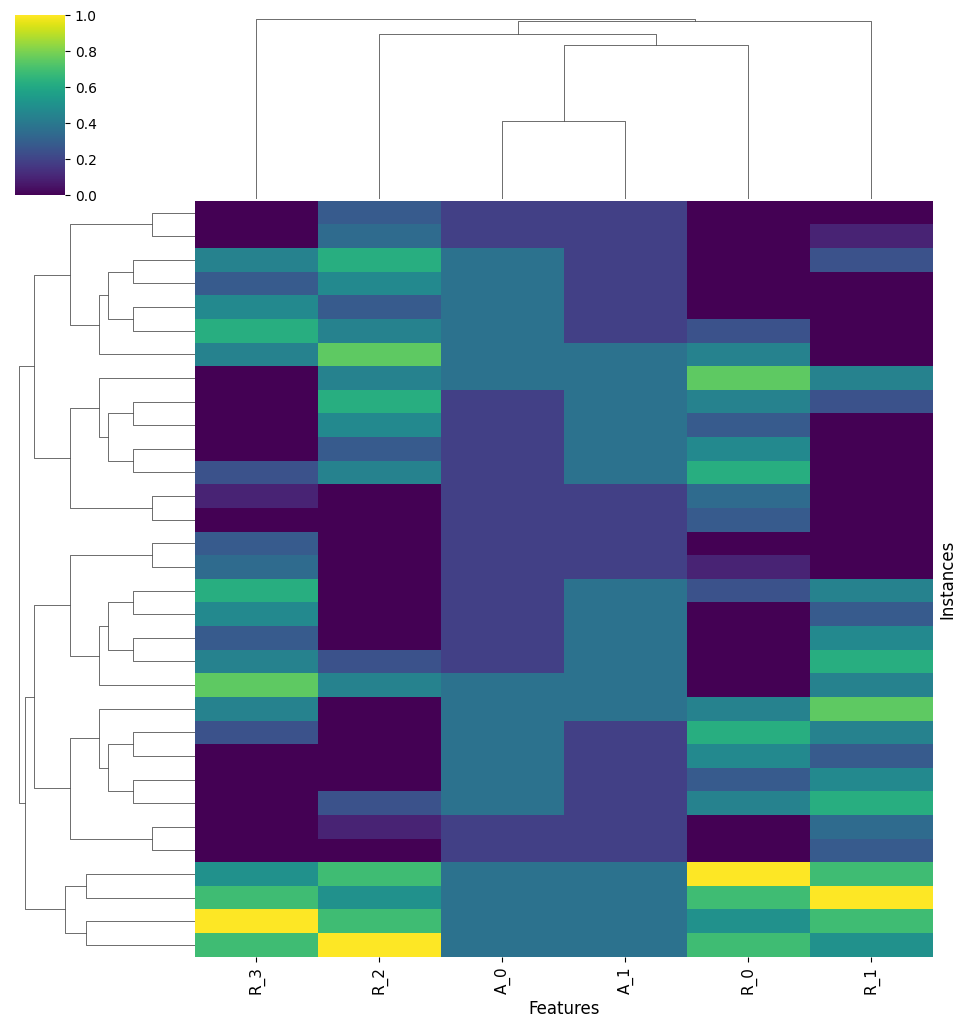

In [11]:
if full_run:
    ft_df = pd.read_csv(output_folder+'/'+str(output_name)+'_ft.csv', index_col='id')
    heros.FT.plot_clustered_ft_heatmap(ft_df, feature_names, show=True, save=True, output_path=folder_path, data_name=output_name)

***
## Prediction (With Rule Population)
### Predict Outcomes and Evaluate With Classificaton Report

In [12]:
predictions = heros.predict(X,top_rule_set=False)
print(classification_report(predictions, y, digits=8))


              precision    recall  f1-score   support

           0  0.87500000 0.82352941 0.84848485        34
           1  0.81250000 0.86666667 0.83870968        30

    accuracy                      0.84375000        64
   macro avg  0.84375000 0.84509804 0.84359726        64
weighted avg  0.84570312 0.84375000 0.84390274        64



### Get Prediction Probabilities

In [13]:
predictions = heros.predict_proba(X,top_rule_set=False)
print(predictions)

[{0: 1.0, 1: 0.0} {0: 0.9179487179487179, 1: 0.08205128205128205}
 {0: 0.8678899082568807, 1: 0.13211009174311927}
 {0: 0.6967213114754098, 1: 0.30327868852459017}
 {0: 0.8257425742574257, 1: 0.17425742574257425}
 {0: 0.6379310344827587, 1: 0.3620689655172414}
 {0: 0.5566037735849056, 1: 0.44339622641509435}
 {0: 0.3370288248337029, 1: 0.6629711751662971}
 {0: 0.688622754491018, 1: 0.31137724550898205}
 {0: 0.49122807017543857, 1: 0.5087719298245614}
 {0: 0.3865546218487395, 1: 0.6134453781512605}
 {0: 0.19801980198019803, 1: 0.801980198019802}
 {0: 0.3247863247863248, 1: 0.6752136752136753}
 {0: 0.15594541910331383, 1: 0.8440545808966862}
 {0: 0.0830188679245283, 1: 0.9169811320754717} {0: 0.0, 1: 1.0}
 {0: 1.0, 1: 0.0} {0: 0.8534031413612565, 1: 0.14659685863874344}
 {0: 0.9277504105090312, 1: 0.0722495894909688}
 {0: 0.6976744186046512, 1: 0.3023255813953488}
 {0: 0.7006237006237006, 1: 0.2993762993762994}
 {0: 0.3543307086614173, 1: 0.6456692913385826}
 {0: 0.509090909090909, 1: 0.

***
## HEROS Trained Model Population (Phase 2: Rule-sets)
### Get DataFrame and save to .csv

In [14]:
pop_df = heros.get_model_pop()
pop_df.to_csv(output_folder+'/'+str(output_name)+'_model_pop.csv', index=False)

### Vizualize Model Population on Pareto Front Fitness Landscape

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


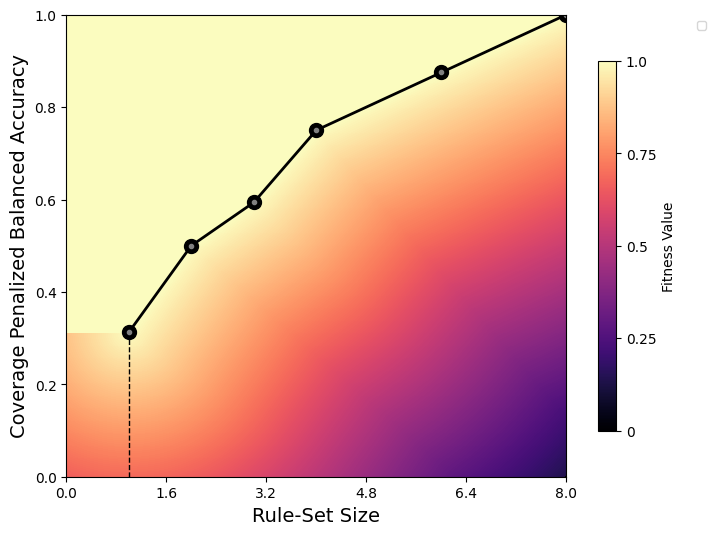

In [15]:
if full_run:
    resolution = 500
    plot_models = True
    heros.get_model_pareto_landscape(resolution, heros.model_population, plot_models, show=True,save=True,output_path=folder_path,data_name=output_name)

***
## HEROS Top Model Identification and Inspection
### Select and Report Top Model (Ranked by Accuracy, Coverage, then Rule Count)

In [16]:
set_df = heros.get_top_model_rules()
set_df.to_csv(output_folder+'/'+str(output_name)+'_top_model_rules.csv', index=False)
print(set_df)

  Condition Indexes Condition Values  Action  Numerosity  Fitness  \
0         [0, 1, 3]        [0, 1, 0]       0           5      1.0   
1         [0, 1, 4]        [1, 0, 0]       0           7      1.0   
2         [0, 1, 5]        [1, 1, 1]       1           5      1.0   
3         [0, 1, 3]        [0, 1, 1]       1           5      1.0   
4         [0, 1, 2]        [0, 0, 0]       0           3      1.0   
5         [0, 1, 2]        [0, 0, 1]       1           8      1.0   
6         [0, 1, 4]        [1, 0, 1]       1          10      1.0   
7         [0, 1, 5]        [1, 1, 0]       0           6      1.0   

   Useful Accuracy  Useful Coverage  Accuracy  Match Cover  Correct Cover  \
0              1.0              4.0       1.0            8              8   
1              1.0              4.0       1.0            8              8   
2              1.0              4.0       1.0            8              8   
3              1.0              4.0       1.0            8            

### Select and Report Indexed Model

In [17]:
model_index = 1
set_df = heros.get_indexed_model_rules(model_index)
print(set_df)

  Condition Indexes Condition Values  Action  Numerosity  Fitness  \
0         [0, 1, 3]        [0, 1, 0]       0           5      1.0   
1         [0, 1, 4]        [1, 0, 0]       0           7      1.0   
2         [0, 1, 5]        [1, 1, 1]       1           5      1.0   
3         [0, 1, 3]        [0, 1, 1]       1           5      1.0   
4         [0, 1, 2]        [0, 0, 0]       0           3      1.0   
5         [0, 1, 2]        [0, 0, 1]       1           8      1.0   
6         [0, 1, 4]        [1, 0, 1]       1          10      1.0   
7         [0, 1, 5]        [1, 1, 0]       0           6      1.0   
8         [1, 3, 5]        [1, 1, 1]       1          17      1.0   

   Useful Accuracy  Useful Coverage  Accuracy  Match Cover  Correct Cover  \
0              1.0              4.0       1.0            8              8   
1              1.0              4.0       1.0            8              8   
2              1.0              4.0       1.0            8              8   
3

In [18]:
model_index = 2
set_df = heros.get_indexed_model_rules(model_index)
print(set_df)

  Condition Indexes Condition Values  Action  Numerosity  Fitness  \
0         [0, 1, 3]        [0, 1, 0]       0           5      1.0   
1         [0, 1, 4]        [1, 0, 0]       0           7      1.0   
2         [0, 1, 5]        [1, 1, 1]       1           5      1.0   
3         [0, 1, 3]        [0, 1, 1]       1           5      1.0   
4         [0, 1, 2]        [0, 0, 0]       0           3      1.0   
5         [0, 1, 2]        [0, 0, 1]       1           8      1.0   
6         [0, 1, 4]        [1, 0, 1]       1          10      1.0   
7         [0, 1, 5]        [1, 1, 0]       0           6      1.0   
8         [1, 2, 4]        [0, 1, 1]       1           9      1.0   

   Useful Accuracy  Useful Coverage  Accuracy  Match Cover  Correct Cover  \
0              1.0              4.0       1.0            8              8   
1              1.0              4.0       1.0            8              8   
2              1.0              4.0       1.0            8              8   
3

***
## Prediction (With Top Model)
### Predict Outcomes and Evaluate With Classificaton Report

In [19]:
predictions = heros.predict(X,top_rule_set=True)
print(classification_report(predictions, y, digits=8))

              precision    recall  f1-score   support

           0  1.00000000 1.00000000 1.00000000        32
           1  1.00000000 1.00000000 1.00000000        32

    accuracy                      1.00000000        64
   macro avg  1.00000000 1.00000000 1.00000000        64
weighted avg  1.00000000 1.00000000 1.00000000        64



### Get Prediction Probabilities

In [20]:
predictions = heros.predict_proba(X,top_rule_set=True)
print(predictions)

[{0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0}
 {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0}
 {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0}
 {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0}
 {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0}
 {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0}
 {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0}
 {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0}
 {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0}
 {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0}
 {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0}
 {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0}
 {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0} {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0}
 {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0} {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0}
 {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0}

***
## Pickle Trained HEROS Object (For Future Use)

In [21]:
with open(output_folder+'/'+str(output_name)+'.pickle', 'wb') as f:
    pickle.dump(heros, f)

***
## Open Pickled FIBERS Object (Example)

In [22]:
with open(output_folder+'/'+str(output_name)+'.pickle', 'rb') as f:
    heros = pickle.load(f)

pop_df = heros.get_pop()